In [1]:
import pandas as pd
from pandas import DataFrame, to_datetime
import numpy as np
import os
import datetime
from dateutil.relativedelta import relativedelta
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable  
from matplotlib.colorbar import ColorbarBase
from matplotlib.dates import DateFormatter 
%matplotlib inline
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.ar_model import AutoReg
from prophet import Prophet

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Connect SQLite Data-Warehouse

In [4]:
# SQLite Datenbank Pfad 
SQLITE_FILE_PATH = os.path.join("..", "output", "dwh.sqlite3")

In [5]:
# Connection zur Datenbank 
con = sqlite3.connect(SQLITE_FILE_PATH)

# Select Data

## Datenabfrage und Aggregation der Daten nach Anzahl der installierten PV-Anlagen

In [6]:
query = """  
SELECT
    marktstammdaten.Inbetriebnahmedatum AS Datum,
    COUNT(*) AS Anzahl_PV_Anlagen,
    einspeiseverguetung.Einspeiseverguetung_kleine_PV_Anlagen AS Einspeiseverguetung,
    strompreis.Strom_Verbraucherpreis AS Strompreis
   
FROM marktstammdaten
LEFT JOIN strompreis
ON strftime('%Y', marktstammdaten.Inbetriebnahmedatum) = strompreis.Jahr
LEFT JOIN einspeiseverguetung
ON marktstammdaten.Inbetriebnahmedatum = einspeiseverguetung.Datum

WHERE marktstammdaten.Inbetriebnahmedatum BETWEEN '2005-01-01' AND '2023-06-30'
GROUP BY marktstammdaten.Inbetriebnahmedatum
ORDER BY marktstammdaten.Inbetriebnahmedatum;
"""
marktstd_df = pd.read_sql_query(query, con=con)
#marktstd_df

In [7]:
marktstd_df['ID'] = marktstd_df.index
marktstd_df

,Datum,Anzahl_PV_Anlagen,Einspeiseverguetung,Strompreis,ID
0,2005-01-01 00:00:00,1082,54.53,18.23,0
1,2005-01-02 00:00:00,18,NaN,18.23,1
2,2005-01-03 00:00:00,37,NaN,18.23,2
3,2005-01-04 00:00:00,24,NaN,18.23,3
4,2005-01-05 00:00:00,37,NaN,18.23,4
...,...,...,...,...,...
6745,2023-06-25 00:00:00,1085,NaN,46.27,6745
6746,2023-06-26 00:00:00,3123,NaN,46.27,6746
6747,2023-06-27 00:00:00,2654,NaN,46.27,6747
6748,2023-06-28 00:00:00,2475,NaN,46.27,6748


In [8]:
marktstd_df['Datum'] = pd.to_datetime(marktstd_df['Datum'])

In [9]:
marktstd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750 entries, 0 to 6749
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                6750 non-null   datetime64[ns]
 1   Anzahl_PV_Anlagen    6750 non-null   int64         
 2   Einspeiseverguetung  222 non-null    float64       
 3   Strompreis           6750 non-null   float64       
 4   ID                   6750 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 263.8 KB


In [10]:
marktstd_df.isna().sum()

Datum                     0
Anzahl_PV_Anlagen         0
Einspeiseverguetung    6528
Strompreis                0
ID                        0
dtype: int64

## Datenabfrage und Aggregation der Daten nach installierter Brutto-Leistung in kWh

In [11]:
query_leistung = """  
SELECT
    marktstammdaten.Inbetriebnahmedatum AS Datum,
    SUM(marktstammdaten.Bruttoleistung) AS Gesamt_Bruttoleistung,
    einspeiseverguetung.Einspeiseverguetung_kleine_PV_Anlagen AS Einspeiseverguetung,
    strompreis.Strom_Verbraucherpreis AS Strompreis
   
FROM marktstammdaten
LEFT JOIN strompreis
ON strftime('%Y', marktstammdaten.Inbetriebnahmedatum) = strompreis.Jahr
LEFT JOIN einspeiseverguetung
ON marktstammdaten.Inbetriebnahmedatum = einspeiseverguetung.Datum

WHERE marktstammdaten.Inbetriebnahmedatum BETWEEN '2005-01-01' AND '2023-06-30'
GROUP BY marktstammdaten.Inbetriebnahmedatum
ORDER BY marktstammdaten.Inbetriebnahmedatum;
"""
leistung_df = pd.read_sql_query(query_leistung, con=con)
leistung_df

,Datum,Gesamt_Bruttoleistung,Einspeiseverguetung,Strompreis
0,2005-01-01 00:00:00,14284.569,54.53,18.23
1,2005-01-02 00:00:00,210.701,NaN,18.23
2,2005-01-03 00:00:00,574.495,NaN,18.23
3,2005-01-04 00:00:00,329.886,NaN,18.23
4,2005-01-05 00:00:00,300.128,NaN,18.23
...,...,...,...,...
6745,2023-06-25 00:00:00,9252.687,NaN,46.27
6746,2023-06-26 00:00:00,80919.715,NaN,46.27
6747,2023-06-27 00:00:00,141311.376,NaN,46.27
6748,2023-06-28 00:00:00,35296.301,NaN,46.27


In [12]:
# Spalte 'unique_id' einfügen (für Forecasting-Modelle)
leistung_df['unique_id'] = 1
leistung_df

,Datum,Gesamt_Bruttoleistung,Einspeiseverguetung,Strompreis,unique_id
0,2005-01-01 00:00:00,14284.569,54.53,18.23,1
1,2005-01-02 00:00:00,210.701,NaN,18.23,1
2,2005-01-03 00:00:00,574.495,NaN,18.23,1
3,2005-01-04 00:00:00,329.886,NaN,18.23,1
4,2005-01-05 00:00:00,300.128,NaN,18.23,1
...,...,...,...,...,...
6745,2023-06-25 00:00:00,9252.687,NaN,46.27,1
6746,2023-06-26 00:00:00,80919.715,NaN,46.27,1
6747,2023-06-27 00:00:00,141311.376,NaN,46.27,1
6748,2023-06-28 00:00:00,35296.301,NaN,46.27,1


In [13]:
leistung_df['Datum'] = pd.to_datetime(leistung_df['Datum'])

In [14]:
leistung_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750 entries, 0 to 6749
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Datum                  6750 non-null   datetime64[ns]
 1   Gesamt_Bruttoleistung  6750 non-null   float64       
 2   Einspeiseverguetung    222 non-null    float64       
 3   Strompreis             6750 non-null   float64       
 4   unique_id              6750 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 263.8 KB


In [15]:
leistung_df.isna().sum()

Datum                       0
Gesamt_Bruttoleistung       0
Einspeiseverguetung      6528
Strompreis                  0
unique_id                   0
dtype: int64

# Visualisierung der Daten

## In Betrieb genommene PV-Anlagen zwischen 01.01.2005 und 30.06.2023

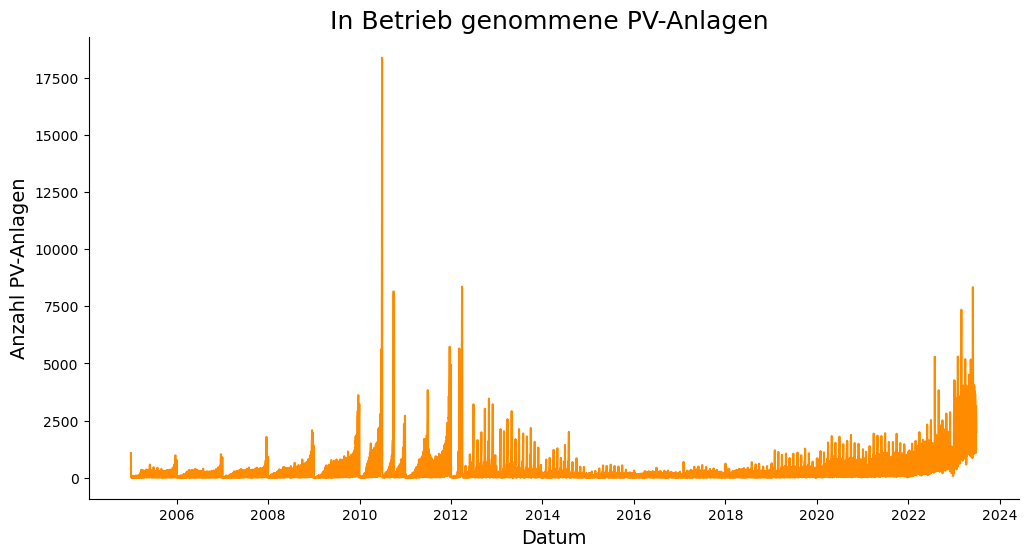

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(marktstd_df['Datum'], marktstd_df['Anzahl_PV_Anlagen'], linestyle='-', color='darkorange')

plt.title("In Betrieb genommene PV-Anlagen ", fontsize=18)
plt.xlabel('Datum', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
date_form = DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_form)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

## In Betrieb genommene PV-Anlagen zwischen 01.01.2022 und 30.06.2023

In [17]:
# Datum ab 2022 auswählen
marktstd_select = marktstd_df[marktstd_df['Datum'].dt.year >= 2022]

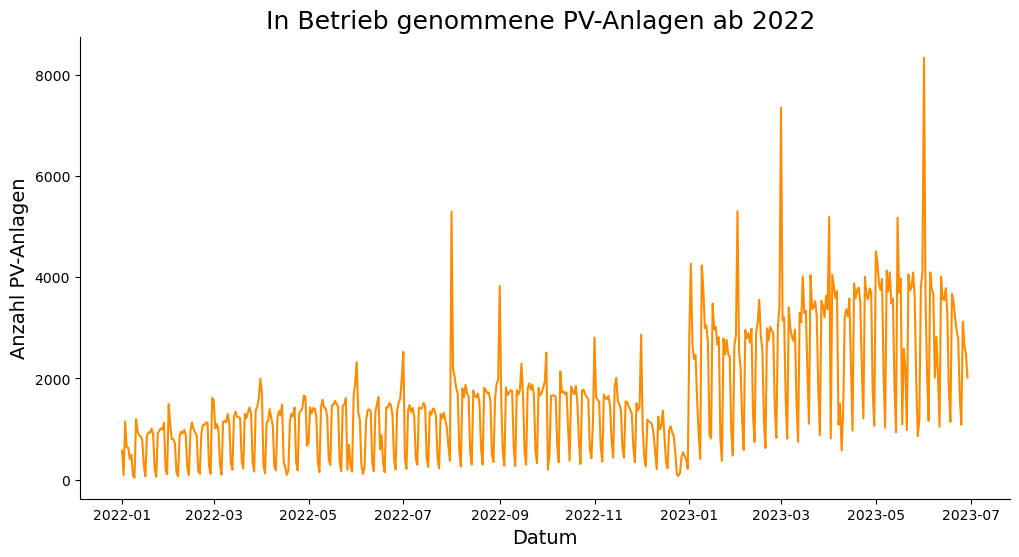

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(marktstd_select['Datum'], marktstd_select['Anzahl_PV_Anlagen'], linestyle='-', color='darkorange')

plt.title("In Betrieb genommene PV-Anlagen ab 2022 ", fontsize=18)
plt.xlabel('Datum', fontsize=14)
plt.ylabel('Anzahl PV-Anlagen', fontsize=14)
date_form = DateFormatter("%Y-%m")
plt.gca().xaxis.set_major_formatter(date_form)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

## Installierte Leistung in kWh gesamt zwischen 01.01.2005 und 30.06.2023

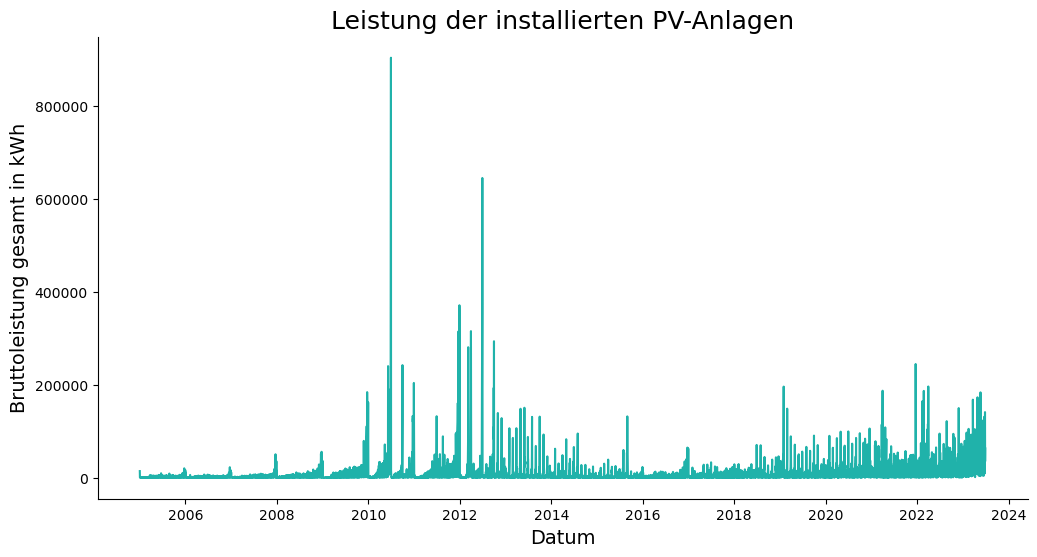

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(leistung_df['Datum'], leistung_df['Gesamt_Bruttoleistung'], linestyle='-', color='lightseagreen')

plt.title("Leistung der installierten PV-Anlagen", fontsize=18)
plt.xlabel('Datum', fontsize=14)
plt.ylabel('Bruttoleistung gesamt in kWh', fontsize=14)
date_form = DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_form)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

## Installierte Leistung in kWh gesamt zwischen 01.01.2022 und 30.06.2023

In [20]:
# Datum ab 2022 auswählen
leistung_select = leistung_df[leistung_df['Datum'].dt.year >= 2022]

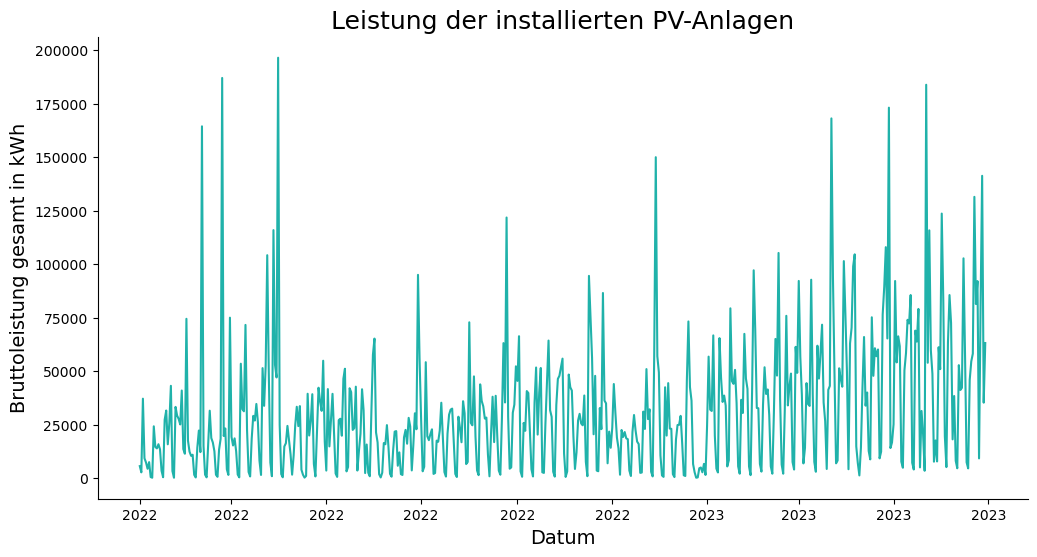

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(leistung_select['Datum'], leistung_select['Gesamt_Bruttoleistung'], linestyle='-', color='lightseagreen')

plt.title("Leistung der installierten PV-Anlagen", fontsize=18)
plt.xlabel('Datum', fontsize=14)
plt.ylabel('Bruttoleistung gesamt in kWh', fontsize=14)
date_form = DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_form)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

# Vergleich unterschiedlicher Vorhersage-Modelle der ARMA-Familie    
Quellen:    
https://medium.datadriveninvestor.com/classification-of-advanced-time-series-forecasting-methods-and-when-to-use-them-51709e683b48    
https://builtin.com/data-science/time-series-forecasting-python   
https://towardsdatascience.com/time-series-forecasting-prediction-intervals-360b1bf4b085    
https://towardsdatascience.com/timegpt-the-first-foundation-model-for-time-series-forecasting-bf0a75e63b3a    
https://towardsdatascience.com/timesnet-the-latest-advance-in-time-series-forecasting-745b69068c9c   
https://xthemadgenius.medium.com/predicting-tomorrow-how-mlforecast-makes-time-series-forecasting-easy-and-accurate-e3d053f783d6   


## Predict with Autoregressive Moving Average (ARMA)

In [22]:
# Spalte Datum formatieren und als Index festlegen
columns = ['Datum', 'Gesamt_Bruttoleistung']
leistung = leistung_df[columns].copy()

leistung.index = pd.to_datetime(leistung_df['Datum'], format='%Y-%m-%d')
leistung.drop(columns=['Datum'], inplace=True)

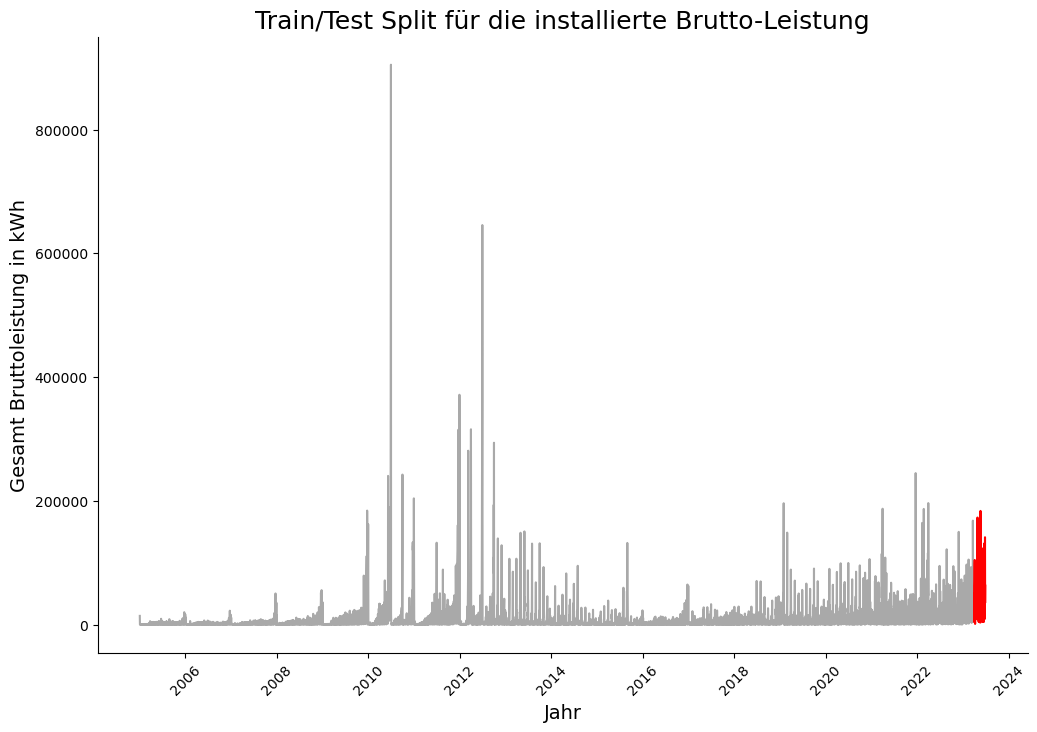

In [23]:
# Split in Tainings- und Testdaten
train = leistung[leistung.index < pd.to_datetime("2023-04-01", format='%Y-%m-%d')]
test = leistung[leistung.index >= pd.to_datetime("2023-04-01", format='%Y-%m-%d')]

fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(train, color = "darkgrey")
plt.plot(test, color = "red")
plt.ylabel('Gesamt Bruttoleistung in kWh', fontsize=14)
plt.xlabel('Jahr', fontsize=14)
plt.xticks(rotation=45)
plt.title("Train/Test Split für die installierte Brutto-Leistung", fontsize=18)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [24]:
#train

In [25]:
#test

In [26]:
y = train['Gesamt_Bruttoleistung']

In [27]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [28]:
ARMAmodel = ARMAmodel.fit()

In [29]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_ARMA = y_pred_df["Predictions"] 
y_pred_out_ARMA

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a mo

Datum
2023-04-01    5.214685e+04
2023-04-02    3.592730e+04
2023-04-03    2.475262e+04
2023-04-04    1.705366e+04
2023-04-05    1.174936e+04
                  ...     
2023-06-25    9.203083e-10
2023-06-26    6.340593e-10
2023-06-27    4.368440e-10
2023-06-28    3.009698e-10
2023-06-29    2.073574e-10
Name: Predictions, Length: 90, dtype: float64

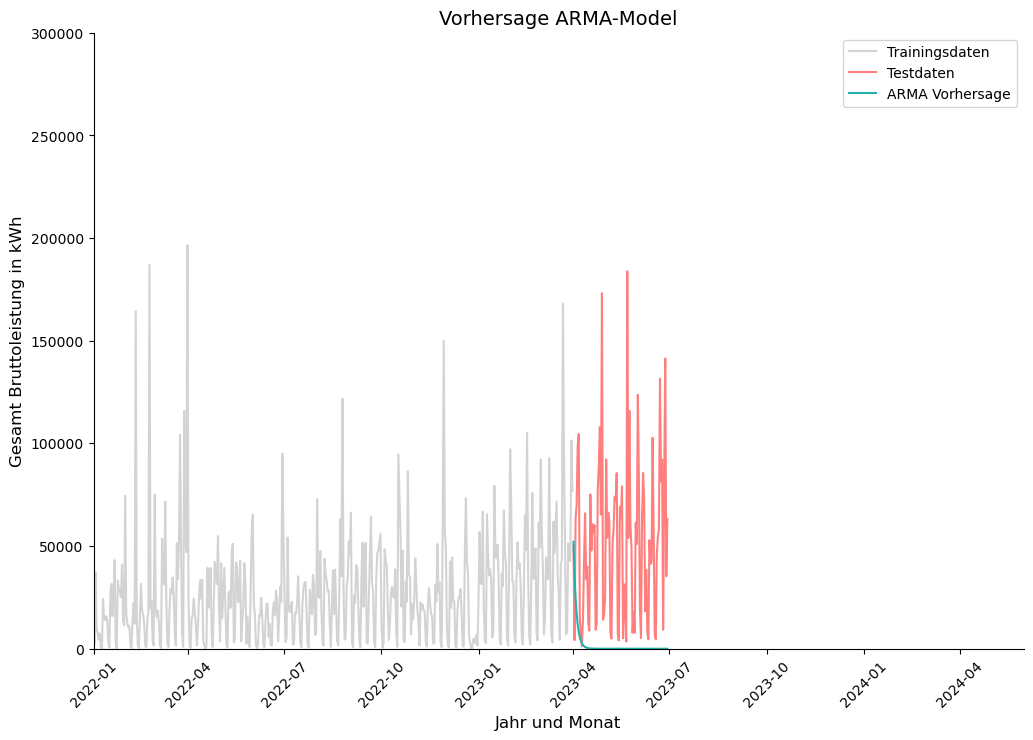

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(train.index, train['Gesamt_Bruttoleistung'], color='darkgrey', alpha=0.5, label='Trainingsdaten')
plt.plot(test.index, test['Gesamt_Bruttoleistung'], color='red', alpha=0.5, label='Testdaten')

plt.plot(y_pred_out_ARMA, color='lightseagreen', label = 'ARMA Vorhersage')
plt.ylabel('Gesamt Bruttoleistung in kWh', fontsize=12)
plt.xlabel('Jahr und Monat', fontsize=12)
plt.title("Vorhersage ARMA-Model", fontsize=14)

plt.xlim(pd.Timestamp('2022-01-01'), None)  # zoom in
plt.ylim(0, 300000)
plt.xticks(rotation=45)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [31]:
# Evaluieren der Performance mittels RMSE (Mittlere quadratische Abweichung)
arma_rmse = np.sqrt(mean_squared_error(test["Gesamt_Bruttoleistung"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  63942.85368927985


## Predict with Autoregressive Integrated Moving Average (ARIMA)

In [32]:
ARIMAmodel = ARIMA(y, order = (6, 2, 6))
ARIMAmodel = ARIMAmodel.fit()

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a mo

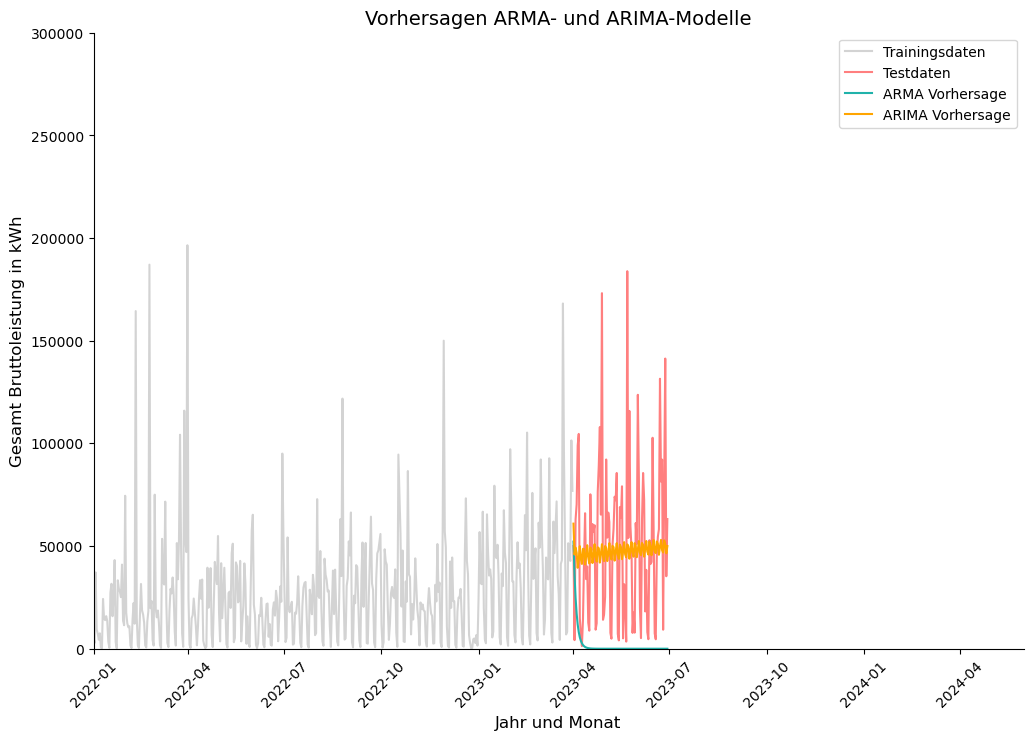

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(train.index, train['Gesamt_Bruttoleistung'], color='darkgrey', alpha=0.5, label='Trainingsdaten')
plt.plot(test.index, test['Gesamt_Bruttoleistung'], color='red', alpha=0.5, label='Testdaten')
plt.plot(y_pred_out_ARMA, color='lightseagreen', label = 'ARMA Vorhersage')

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_ARIMA = y_pred_df["Predictions"] 
plt.plot(y_pred_out_ARIMA, color='orange', label = 'ARIMA Vorhersage')
plt.legend()
plt.ylabel('Gesamt Bruttoleistung in kWh', fontsize=12)
plt.xlabel('Jahr und Monat', fontsize=12)
plt.title("Vorhersagen ARMA- und ARIMA-Modelle", fontsize=14)

plt.xlim(pd.Timestamp('2022-01-01'), None)  # zoom in
plt.ylim(0, 300000)
plt.xticks(rotation=45)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [34]:
# Evaluieren der Performance mittels RMSE (Mittlere quadratische Abweichung)
arma_rmse = np.sqrt(mean_squared_error(test["Gesamt_Bruttoleistung"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  38456.66685639005


## Predict with Seasonal ARIMA (SARIMA)

In [35]:
SARIMAXmodel = SARIMAX(y, order = (6, 2, 6), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a mo

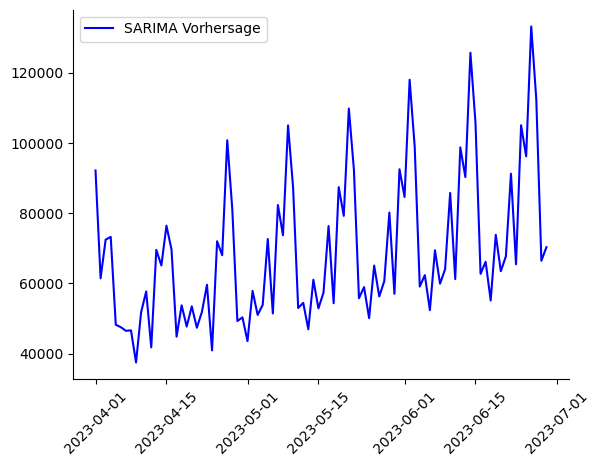

In [36]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_SARIMA = y_pred_df["Predictions"] 
plt.plot(y_pred_out_SARIMA, color='Blue', label = 'SARIMA Vorhersage')
plt.xticks(rotation=45)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [37]:
# Evaluieren der Performance mittels RMSE
arma_rmse = np.sqrt(mean_squared_error(test["Gesamt_Bruttoleistung"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  43102.63903948238


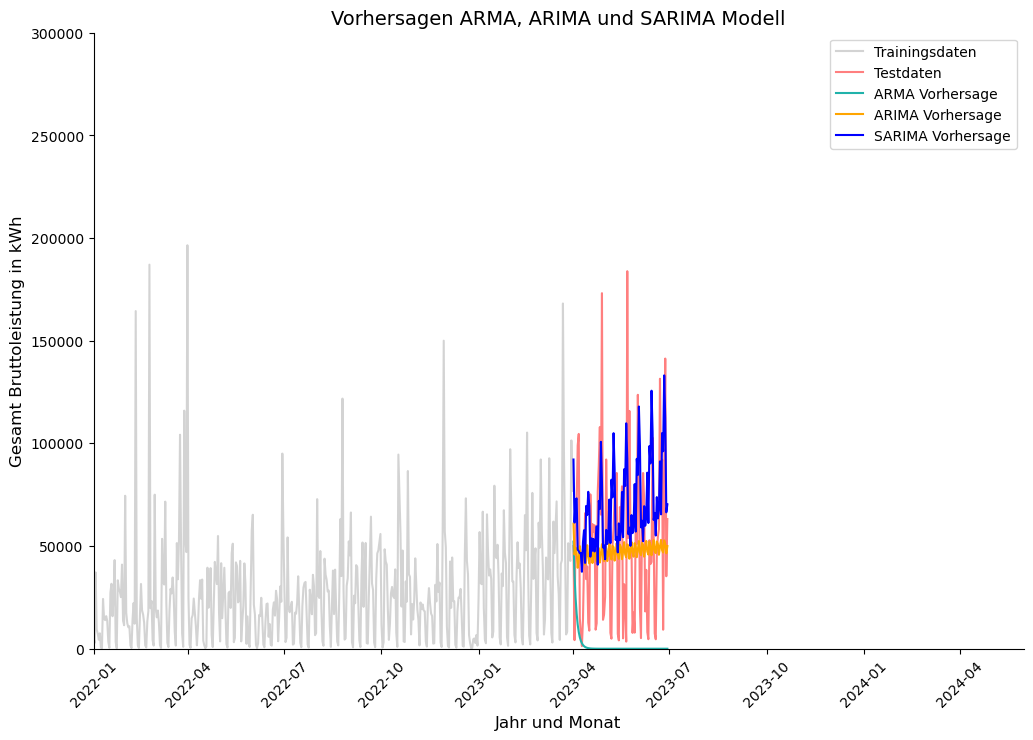

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(train.index, train['Gesamt_Bruttoleistung'], color='darkgrey', alpha=0.5, label='Trainingsdaten')
plt.plot(test.index, test['Gesamt_Bruttoleistung'], color='red', alpha=0.5, label='Testdaten')
plt.plot(y_pred_out_ARMA, color='lightseagreen', label='ARMA Vorhersage')  
plt.plot(y_pred_out_ARIMA, color='orange', label='ARIMA Vorhersage')  
plt.plot(y_pred_out_SARIMA, color='blue', label='SARIMA Vorhersage')  

plt.ylabel('Gesamt Bruttoleistung in kWh', fontsize=12)
plt.xlabel('Jahr und Monat', fontsize=12)
plt.title("Vorhersagen ARMA, ARIMA und SARIMA Modell", fontsize=14)
plt.xlim(pd.Timestamp('2022-01-01'), None)  # Zoom in auf 2022
plt.ylim(0, 300000)  
plt.xticks(rotation=45)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()

# Hyperparameter Tuning (Grid Search)
Quellen:   
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/    


In [39]:
leistung.head(5)

,Gesamt_Bruttoleistung
Datum,
2005-01-01,14284.569
2005-01-02,210.701
2005-01-03,574.495
2005-01-04,329.886
2005-01-05,300.128


In [40]:
# one-step sarima forecast
def sarima_forecast(history, config):
	# print('sarima_forecast')
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	# print('sarima_forecast -> ', yhat[0])
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	# print('walk_forward_validatio')
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		try:
		# fit model and make forecast for history
			yhat = sarima_forecast(history, cfg)
    		# store forecast in list of predictions
			predictions.append(yhat)
    		# add actual observation to history for the next loop
			history.append(test[i])
		except:
			return None
	# estimate prediction error
	error = measure_rmse(test, predictions)
	# print('walk_forward_validation - current error -> ', error)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	# print('score_model')
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg, True) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg, True) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models


In [41]:
# define dataset
#series = leistung
#data = series.values
#print(data.shape)
# data split
#n_test = 89
# model configs
#cfg_list = sarima_configs()
# grid search
#scores = grid_search(data, cfg_list, n_test, False)
#print('done')
# list top 3 configs
#for cfg, error in scores[:3]:
#    print(cfg, error)

# Code Block wurde auskommentiert, da die die Suche sehr lange dauert.

**Grid Search Ergebnisse:**   
[(2, 1, 2), (0, 0, 0, 0), 't'] 41837.30284649738  
[(1, 1, 1), (0, 0, 0, 0), 't'] 41879.88937715279    
[(2, 1, 2), (0, 0, 0, 0), 'n'] 41884.39036622397    

# Prognose mit dem optimierten SARIMA Model   
Bruttoleistung die installierten PV-Anlagen bis Ende 2023   
Quellen:   
https://medium.datadriveninvestor.com/step-by-step-guide-to-time-series-forecasting-with-sarima-models-215d27c985f3   
https://puneet166.medium.com/time-series-forecasting-how-to-predict-future-data-using-arma-arima-and-sarima-model-8bd20597cc7b   

In [42]:
SARIMAXmodel_opt = SARIMAX(y, order = (2, 1, 2), seasonal_order=(0, 0, 0, 0), trend='t')
SARIMAXmodel_opt = SARIMAXmodel_opt.fit()
print(SARIMAXmodel_opt.summary())

C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\neuralforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 SARIMAX Results                                 
Dep. Variable:     Gesamt_Bruttoleistung   No. Observations:                 6660
Model:                  SARIMAX(2, 1, 2)   Log Likelihood              -76005.346
Date:                   Sun, 21 Apr 2024   AIC                         152022.692
Time:                           12:16:53   BIC                         152063.514
Sample:                                0   HQIC                        152036.794
                                  - 6660                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0013      0.002      0.665      0.506      -0.003       0.005
ar.L1         -0.3566      2.526     -0.141      0.888      -5.308       4.595
ar.L2          0.5053      1

**Ergebnisse Model Summary**       
Die Koeffizienten der AR(autoregressive) und MA(moving average) Terme sind statistisch nicht signifikant (p < 0.05). Möglicherweise kann daher keine zufriedenstelende Modellierung erreicht werden.    
Kovarianzmatrix Warnung: Die Kovarianzmatriist ist singulär oder nahezu singulär. Möglicherweisgibt es Probleme mit der Stabilität der Schätzer oder der Konvergenz des Models.    
Heteroskedastizität: Die Heteroskedastizitätswarnung deutet darauf hin, dass die Varianz der Fehler nicht konstant ist und möglicherweise nicht angemessen erfasst wird.     

In [43]:
# Calculate MSE
mse = mean_squared_error(test["Gesamt_Bruttoleistung"].values, y_pred_df["Predictions"])
print("Mean Squared Error:", mse)

Mean Squared Error: 1857837492.167911


# Prognose SARIMA auf Monats-Basis

**Design-Entscheidung zur Verringerung der Komplexität**    
Die Daten wurden täglich erfasst, was große Schwankungen und damit eine unnötige Komplexität in den Datensatz bringt.    
Daher werden die Daten auf Monats-Ebene agregiert.

In [44]:
leistung_monat = leistung.resample('M').sum()
leistung_monat

,Gesamt_Bruttoleistung
Datum,
2005-01-31,27177.792
2005-02-28,15392.248
2005-03-31,45071.065
2005-04-30,78801.057
2005-05-31,70106.069
...,...
2023-02-28,998437.425
2023-03-31,1498385.874
2023-04-30,1498152.416


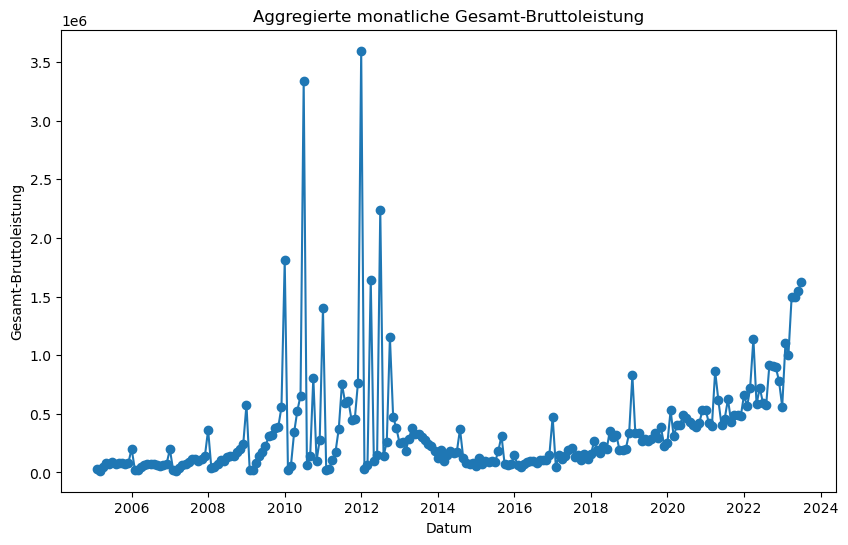

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(leistung_monat.index, leistung_monat['Gesamt_Bruttoleistung'], marker='o', linestyle='-')
plt.title('Aggregierte monatliche Gesamt-Bruttoleistung')
plt.xlabel('Datum')
plt.ylabel('Gesamt-Bruttoleistung')
plt.grid(False)
plt.show()

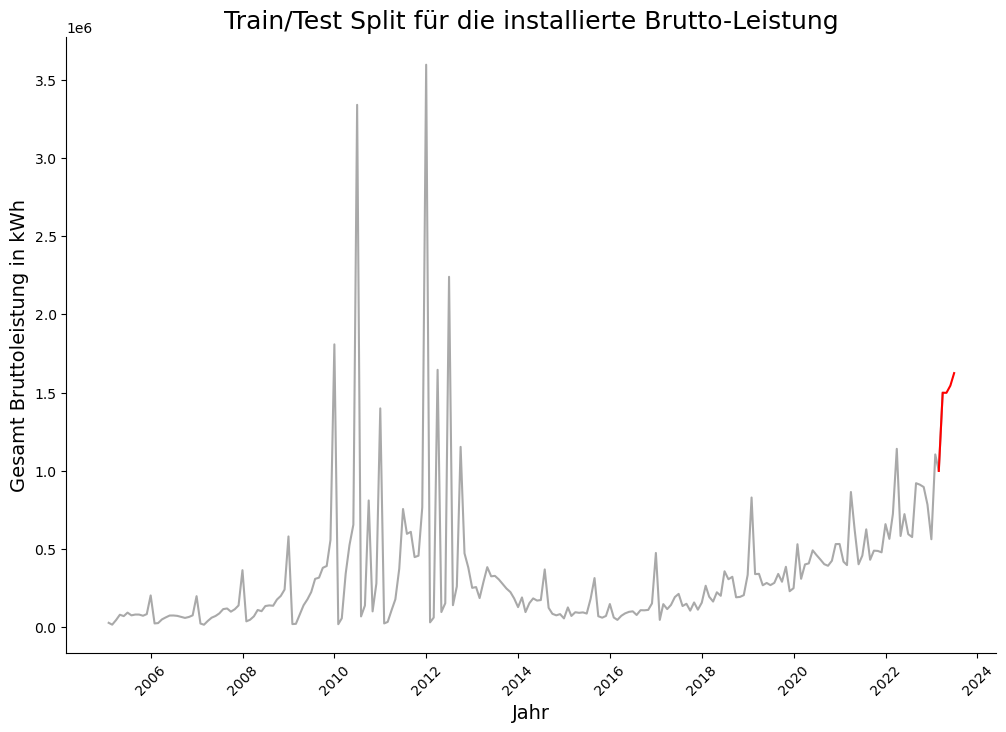

In [46]:
# Split in Tainings- und Testdaten
train = leistung_monat[leistung_monat.index < pd.to_datetime("2023-04-01", format='%Y-%m-%d')]
test = leistung_monat[leistung_monat.index >= pd.to_datetime("2023-02-01", format='%Y-%m-%d')]

fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(train, color = "darkgrey")
plt.plot(test, color = "red")
plt.ylabel('Gesamt Bruttoleistung in kWh', fontsize=14)
plt.xlabel('Jahr', fontsize=14)
plt.xticks(rotation=45)
plt.title("Train/Test Split für die installierte Brutto-Leistung", fontsize=18)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [47]:
#train

In [48]:
#test

In [49]:
y = train['Gesamt_Bruttoleistung']

In [50]:
# one-step sarima forecast
def sarima_forecast(history, config):
	# print('sarima_forecast')
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	# print('sarima_forecast -> ', yhat[0])
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	# print('walk_forward_validatio')
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		try:
		# fit model and make forecast for history
			yhat = sarima_forecast(history, cfg)
    		# store forecast in list of predictions
			predictions.append(yhat)
    		# add actual observation to history for the next loop
			history.append(test[i])
		except:
			return None
	# estimate prediction error
	error = measure_rmse(test, predictions)
	# print('walk_forward_validation - current error -> ', error)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	# print('score_model')
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg, True) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg, True) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models


In [51]:
# define dataset
#series = leistung_monat
#data = series.values
#print(data.shape)
# data split
#n_test = 89
# model configs
#cfg_list = sarima_configs()
# grid search
#scores = grid_search(data, cfg_list, n_test, False)
#print('done')
# list top 3 configs
#for cfg, error in scores[:3]:
#     print(cfg, error)

# Code Block wurde auskommentiert, da die die Suche sehr lange dauert.

**Grid Search Ergebnisse:**    
[(1, 1, 0), (0, 0, 0, 0), 'c'] 165055.2222943624    
[(1, 1, 0), (0, 0, 0, 0), 't'] 165267.08423974883   
[(1, 1, 0), (0, 0, 0, 0), 'n'] 165434.64866616798   

In [52]:
SARIMAXmodel_month = SARIMAX(y, order = (1, 1, 0), seasonal_order=(0, 0, 0, 0), trend='c')
SARIMAXmodel_month = SARIMAXmodel_month.fit()
print(SARIMAXmodel_month.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Gesamt_Bruttoleistung   No. Observations:                  219
Model:                  SARIMAX(1, 1, 0)   Log Likelihood               -3166.147
Date:                   Sun, 21 Apr 2024   AIC                           6338.294
Time:                           12:16:53   BIC                           6348.448
Sample:                       01-31-2005   HQIC                          6342.395
                            - 03-31-2023                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8902.4731   3.41e+04      0.261      0.794   -5.79e+04    7.57e+04
ar.L1         -0.4621      0.020    -22.653      0.000      -0.502      -0.422
sigma2      2.424e+11      0

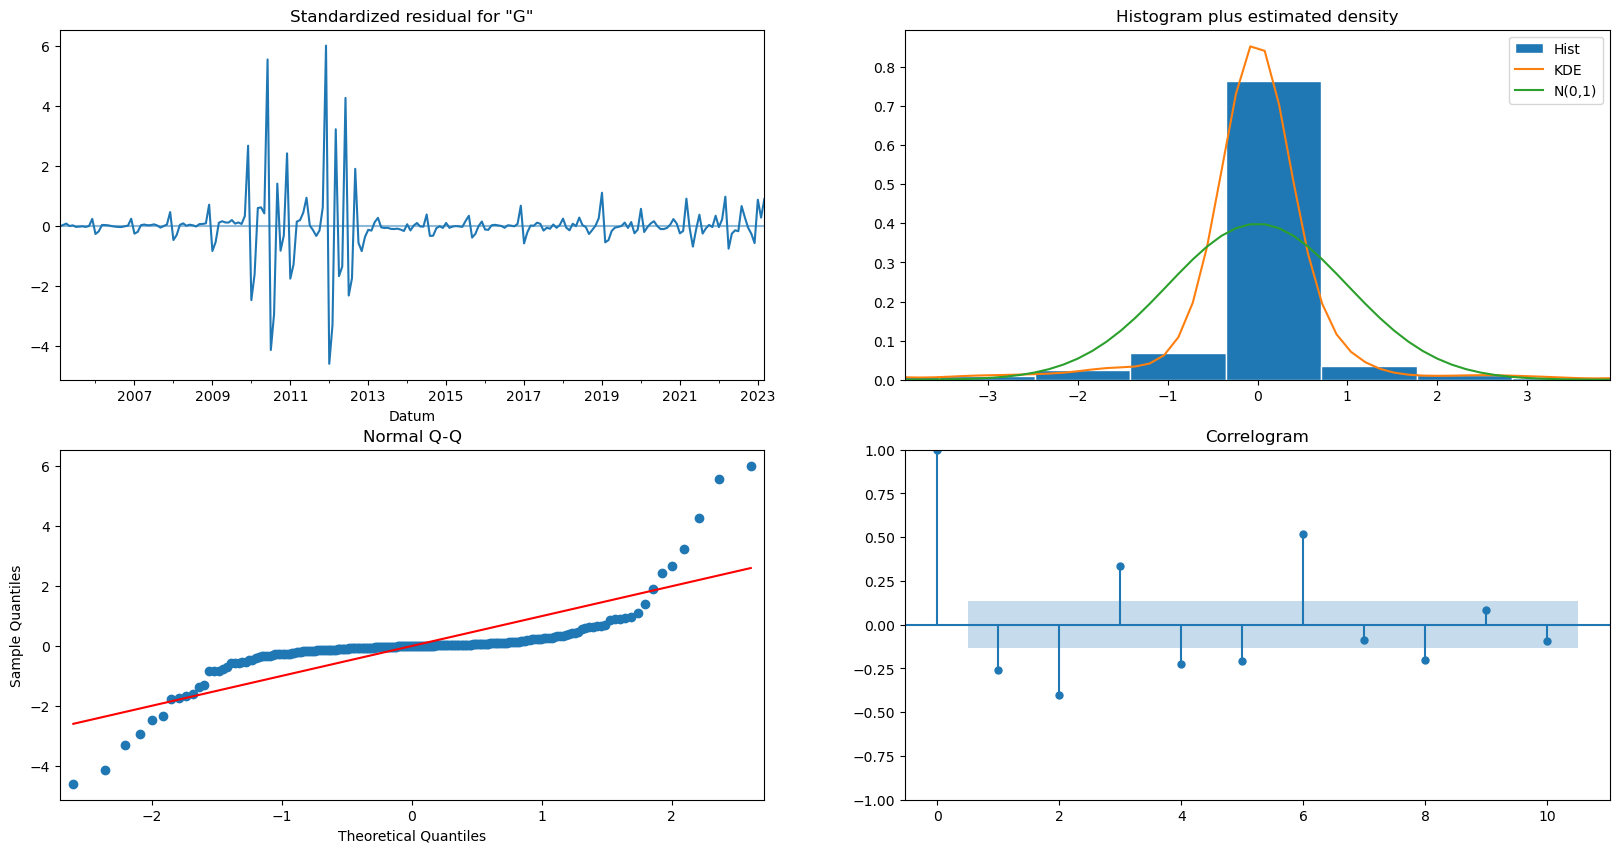

In [53]:
# Diagnostic Plots
# Quelle: https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
SARIMAXmodel_month.plot_diagnostics(figsize=(20, 10))
plt.show()

**Ergebnisse:**   
Es wurden verschiedene Modelle der ARMA Familie getestet.   
Das Sarima-Modell lieferte im Vergleich die besten Ergebnisse, konnte jedoch weder auf Tages- noch aus Monatsbasis hinreichend gute Prognosnen liefern.   
Daher werden weitere Modelle getestet, wobei sich auf die weniger komplexe Monatssicht beschränkt wird.

# Prognose mit Prophet
Quelle: https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [54]:
# Daten für Prophet vorbereiten
data_prophet = leistung_monat.reset_index()  # als DataFrame mit Datumsspalte
data_prophet = data_prophet.rename(columns={'Datum': 'ds', 'Gesamt_Bruttoleistung': 'y'})
data_prophet

,ds,y
0,2005-01-31,27177.792
1,2005-02-28,15392.248
2,2005-03-31,45071.065
3,2005-04-30,78801.057
4,2005-05-31,70106.069
...,...,...
217,2023-02-28,998437.425
218,2023-03-31,1498385.874
219,2023-04-30,1498152.416
220,2023-05-31,1543868.150


## In-Sample Forecast

In [55]:
# Define and fit model
model = Prophet()
model.fit(data_prophet)

12:16:54 - cmdstanpy - INFO - Chain [1] start processing
12:16:54 - cmdstanpy - INFO - Chain [1] done processing


          ds           yhat     yhat_lower    yhat_upper
0 2023-02-01  622981.128823  155672.998293  1.163657e+06
1 2023-03-01  568434.743071   55087.591003  1.078190e+06
2 2023-04-01  811176.539357  310700.261303  1.329713e+06
3 2023-05-01  654659.107924  170235.595858  1.216291e+06
4 2023-06-01  667488.584631  178279.879929  1.191161e+06


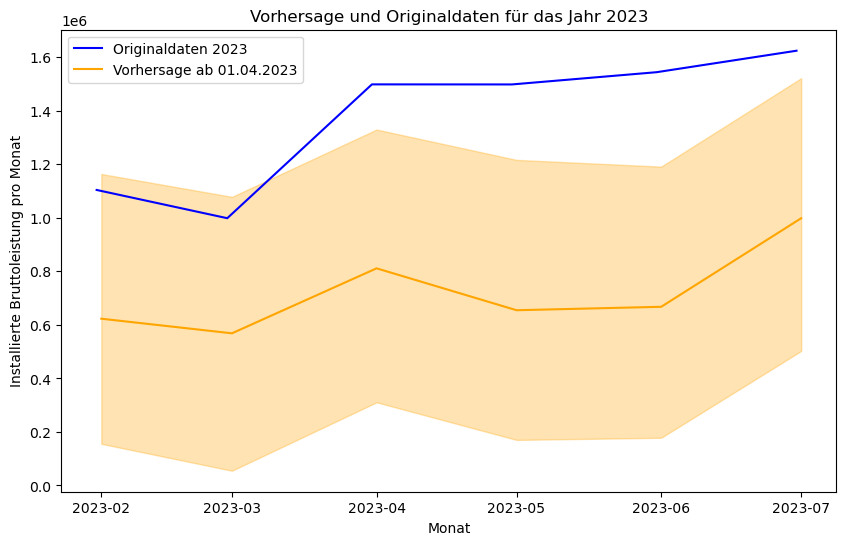

In [56]:
# Originaldaten nur für das Jahr 2023 auswählen
data_2023 = leistung_monat.loc[(leistung_monat.index.year == 2023)]

# Vorbereitung der zukünftigen Daten ab dem 1. April 2023
future = []
for i in range(1, 7):  # Anzahl der Monate
    date = '2023-01-01'  # Startdatum
    future.append([date])
    date = to_datetime(date) + pd.DateOffset(months=i)
    future[-1][0] = date

future = DataFrame(future)
future.columns = ['ds']

# use the model to make a forecast
forecast = model.predict(future)
# filter for 2023
forecast_2023 = forecast[(forecast['ds'].dt.year == 2023) & (forecast['ds'] >= '2023-01-01')]

# summarize the forecast
print(forecast_2023[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# plot forecast
# Plot Originaldaten und Vorhersagen für 2023
plt.figure(figsize=(10, 6))
plt.plot(data_2023.index, data_2023.values, label='Originaldaten 2023', color='blue')
plt.plot(forecast_2023['ds'], forecast_2023['yhat'], label='Vorhersage ab 01.04.2023', color='orange')
plt.fill_between(forecast_2023['ds'], forecast_2023['yhat_lower'], forecast_2023['yhat_upper'], alpha=0.3, color='orange')
plt.title('Vorhersage und Originaldaten für das Jahr 2023')
plt.xlabel('Monat')
plt.ylabel('Installierte Bruttoleistung pro Monat')
plt.legend()
plt.show()

## Out-of-Sample Forecast

In [57]:
# define the period for which we want a prediction
future = list()
for i in range(1, 90):
 date = '2023-07-01'  # Startdatum
 future.append([date])
 date = to_datetime(date) + pd.DateOffset(months=i)
 future[-1][0] = date

future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

           ds          yhat     yhat_lower    yhat_upper
0  2023-08-01  6.651834e+05  201625.877985  1.177427e+06
1  2023-09-01  6.718802e+05  176582.071100  1.192645e+06
2  2023-10-01  7.800978e+05  249776.284241  1.314893e+06
3  2023-11-01  6.998598e+05  192181.715198  1.186215e+06
4  2023-12-01  7.206449e+05  157412.608308  1.199957e+06
..        ...           ...            ...           ...
84 2030-08-01  1.183886e+06  659139.124744  1.698295e+06
85 2030-09-01  1.184234e+06  658631.082064  1.664538e+06
86 2030-10-01  1.312657e+06  807487.692623  1.821230e+06
87 2030-11-01  1.226999e+06  692872.536518  1.752304e+06
88 2030-12-01  1.245519e+06  703525.349319  1.766060e+06

[89 rows x 4 columns]


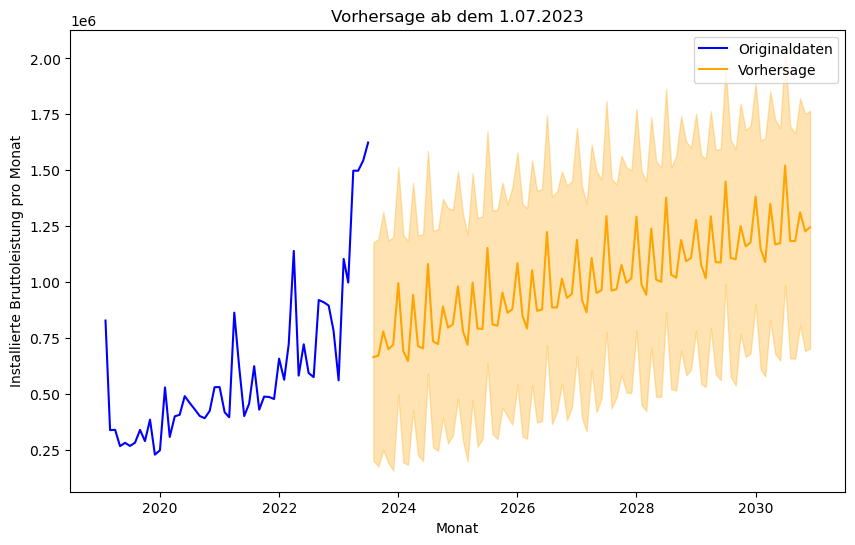

In [58]:
# Originaldaten ab 2021 auswählen
data_2019 = leistung_monat.loc[(leistung_monat.index.year >= 2019)]

# use the model to make a forecast
forecast = model.predict(future)

# filter ab 01.07.2023
forecast_future = forecast[forecast['ds'] >= '2023-07-01']

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# plot forecast ab dem 1.07.2023
plt.figure(figsize=(10, 6))
plt.plot(data_2019.index, data_2019.values, label='Originaldaten', color='blue')
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Vorhersage', color='orange')
plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], alpha=0.3, color='orange')
plt.title('Vorhersage ab dem 1.07.2023')
plt.xlabel('Monat')
plt.ylabel('Installierte Bruttoleistung pro Monat')
plt.legend()
plt.show()

In [59]:
forecast['yhat'] = forecast['yhat'].round().astype(int)
forecast['yhat_lower'] = forecast['yhat_lower'].round().astype(int)
forecast['yhat_upper'] = forecast['yhat_upper'].round().astype(int)

Vorhersagen_2030 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
Vorhersagen_2030

,ds,yhat,yhat_lower,yhat_upper
0,2023-08-01,665183,201626,1177427
1,2023-09-01,671880,176582,1192645
2,2023-10-01,780098,249776,1314893
3,2023-11-01,699860,192182,1186215
4,2023-12-01,720645,157413,1199957
...,...,...,...,...
84,2030-08-01,1183886,659139,1698295
85,2030-09-01,1184234,658631,1664538
86,2030-10-01,1312657,807488,1821230
87,2030-11-01,1226999,692873,1752304


## Manually Evaluate Forecast Model

In [60]:
# create test dataset, remove last 12 months
train = data_prophet.drop(data_prophet.index[-12:])
print(train.tail())

            ds            y
205 2022-02-28   723488.510
206 2022-03-31  1139875.048
207 2022-04-30   582432.765
208 2022-05-31   722436.104
209 2022-06-30   594134.695


In [61]:
# Erstelle Testdatensatz, entferne die letzten 12 Monate
test = data_prophet[-12:]

# Vorhersagen für die letzten 12 Monate
y_true = test['y'].values
y_pred = forecast['yhat'].tail(12).values

# Berechne den MAE
mae = mean_absolute_error(y_true, y_pred)
print('MAE für die letzten 12 Monate: %.3f' % mae)

MAE für die letzten 12 Monate: 372086.110


**Mean Absolute Error: 372.086**   
Der MAE gibt einen durchschnittlichen absoluten Fehler an. Eine kleinere MAE-Wert zeigt an, dass das Modell tendenziell genauer ist.   
Der MAE wird in denselben Einheiten wie die ursprünglichen Daten gemessen. Somit liegt die durchschnittliche absolute Abweichung zwischen den tatsächlichen und den vorhergesagten Werten bei 372.086 kWh (0,37GWh).


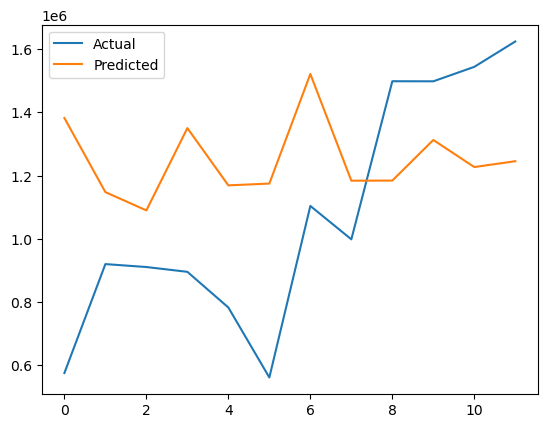

In [62]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Prognose mit LSTM-Modell (Long Short-Term Memory)
Quellen:    
https://towardsdatascience.com/five-practical-applications-of-the-lstm-model-for-time-series-with-code-a7aac0aa85c0    
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/    
https://www.youtube.com/watch?v=c0k-YLQGKjY     
https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing     
https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf     
ChatGPT-Protokoll, Seite 16-18    


## Data Preparation 

In [63]:
df = leistung_monat
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2005-01-31 to 2023-06-30
Freq: M
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gesamt_Bruttoleistung  222 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


In [64]:
df

,Gesamt_Bruttoleistung
Datum,
2005-01-31,27177.792
2005-02-28,15392.248
2005-03-31,45071.065
2005-04-30,78801.057
2005-05-31,70106.069
...,...
2023-02-28,998437.425
2023-03-31,1498385.874
2023-04-30,1498152.416


In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Aufteilen der Daten in Sequenzen (Eingangsdaten) und Ziele (Vorhersage)
@tf.function
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        # Verwende TensorFlow-Operationen, um die Daten zu sammeln
        X.append(tf.slice(data, [i, 0], [n_steps, -1]))
        y.append(tf.slice(data, [end_ix, 0], [1, -1]))
    return tf.convert_to_tensor(X), tf.convert_to_tensor(y)

n_steps = 24  # Anzahl der Monate in jeder Sequenz
sequences, targets = prepare_data(scaled_data, n_steps)

# Ausgabe der Shape der Sequenzen und der Ziele
print("Sequences Shape:", sequences.shape)
print("Targets Shape:", targets.shape)

Sequences Shape: (198, 24, 1)
Targets Shape: (198, 1, 1)


## Built & Train Model

In [66]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [67]:
# Daten in Trainings- und Testdaten aufteilen
train_size = int(len(scaled_data) * 0.7)  # 70% für das Training verwenden
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Trainings- und Testdaten in Sequenzen und Ziele umwandeln
train_sequences, train_targets = prepare_data(train_data, n_steps)
test_sequences, test_targets = prepare_data(test_data, n_steps)

# Modell mit den Trainingsdaten trainieren
model.fit(train_sequences, train_targets, epochs=100, batch_size=32, validation_data=(test_sequences, test_targets))

Epoch 1/100
5/5 [==============================] - 2s 85ms/step - loss: 0.0257 - mae: 0.0739 - val_loss: 0.0334 - val_mae: 0.1570
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0227 - mae: 0.0609 - val_loss: 0.0254 - val_mae: 0.1300
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0210 - mae: 0.0625 - val_loss: 0.0190 - val_mae: 0.1045
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0199 - mae: 0.0697 - val_loss: 0.0146 - val_mae: 0.0846
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0197 - mae: 0.0757 - val_loss: 0.0134 - val_mae: 0.0791
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0196 - mae: 0.0764 - val_loss: 0.0136 - val_mae: 0.0808
Epoch 7/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0195 - mae: 0.0744 - val_loss: 0.0143 - val_mae: 0.0851
Epoch 8/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0196 - mae: 0.06

## In-Sample-Forecast

2/2 [==============================] - 0s 3ms/step


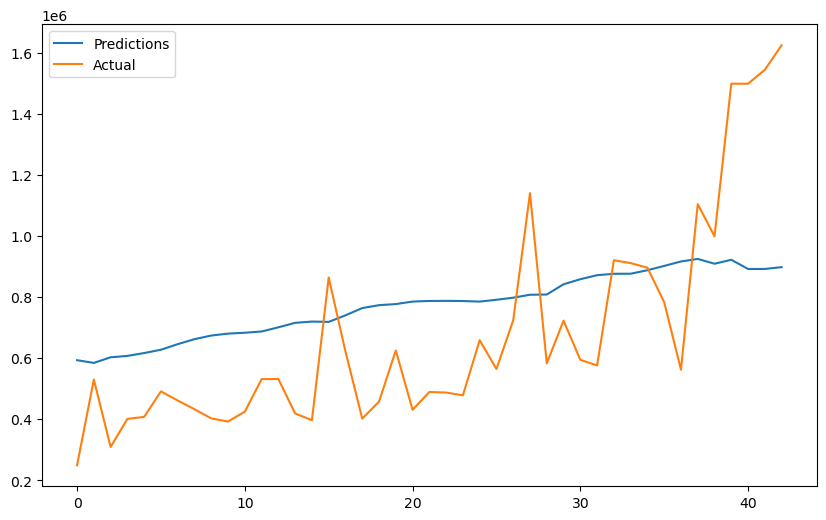

In [68]:
predictions = model.predict(test_sequences)

# Umkehrung der Skalierung für Vorhersagen und Testziele
predictions_inv = scaler.inverse_transform(predictions)
test_targets_inv = scaler.inverse_transform(tf.reshape(test_targets, (-1, 1)))

# Zeige Vorhersagen und Testziele an
plt.figure(figsize=(10, 6))
plt.plot(predictions_inv, label='Predictions')
plt.plot(test_targets_inv, label='Actual')
plt.legend()
plt.show()

## Cross Validation

In [69]:
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Anzahl Folds für die Cross-Validierung
n_splits = 5
random_state = 42

# Initialisierung KFold
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

cv_scores = []

# Iterieren über die Folds
for train_index, test_index in kfold.split(scaled_data):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    
    # Daten in Sequenzen und Ziele umwandeln
    train_sequences, train_targets = prepare_data(train_data, n_steps)
    test_sequences, test_targets = prepare_data(test_data, n_steps)

    # Modell erstellen und trainieren
    cv_model = Sequential()
    cv_model.add(LSTM(units=64, activation='relu', input_shape=(n_steps, 1)))
    cv_model.add(Dense(8, 'relu'))
    cv_model.add(Dense(1, 'linear'))
    cv_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    cv_model.fit(train_sequences, train_targets, epochs=100, batch_size=32, verbose=0)
    
    # Bewertung des Modells auf dem Testdatensatz
    scores = cv_model.evaluate(test_sequences, test_targets, verbose=0)
    print(f"Fold Score (MSE): {scores}")
    cv_scores.append(scores)

# Durchschnittliche Bewertung über alle Folds
average_score = np.mean(cv_scores)
print(f"Average Score (MSE): {average_score}")

Fold Score (MSE): [0.00560258561745286, 0.048339422792196274]
Fold Score (MSE): [0.007162501569837332, 0.06896970421075821]
Fold Score (MSE): [0.003856097115203738, 0.0472087524831295]
Fold Score (MSE): [0.00834400113672018, 0.07726115733385086]
Fold Score (MSE): [0.006536372005939484, 0.0547952838242054]
Average Score (MSE): 0.03280758780892938


## Dropout-Layer

In [70]:
# Anzahl der Folds für die Cross-Validierung
n_splits = 5
random_state = 42

# Initialisierung KFold
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

cv_scores = []

# Iterieren über die Folds
for train_index, test_index in kfold.split(scaled_data):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    
    # Daten in Sequenzen und Ziele umwandeln
    train_sequences, train_targets = prepare_data(train_data, n_steps)
    test_sequences, test_targets = prepare_data(test_data, n_steps)
    
    # Modell erstellen und trainieren
    dropout_model = Sequential()
    dropout_model.add(LSTM(units=64, activation='relu', input_shape=(n_steps, 1)))
    dropout_model.add(Dropout(0.5))  # Dropout mit 50% Auslassung von Neuronen
    dropout_model.add(Dense(8, 'relu'))
    dropout_model.add(Dense(1, 'linear'))
    dropout_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    dropout_model.fit(train_sequences, train_targets, epochs=100, batch_size=32, verbose=0)
    
    # Bewertung des Modells auf dem Testdatensatz
    scores = dropout_model.evaluate(test_sequences, test_targets, verbose=0)
    print(f"Fold Score (MSE): {scores}")
    cv_scores.append(scores)

# Durchschnittliche Bewertung über alle Folds
average_score = np.mean(cv_scores)
print(f"Average Score (MSE): {average_score}")

Fold Score (MSE): [0.005422841291874647, 0.04500297084450722]
Fold Score (MSE): [0.006171051878482103, 0.061381708830595016]
Fold Score (MSE): [0.0053838277235627174, 0.05182927846908569]
Fold Score (MSE): [0.007149897515773773, 0.0701732188463211]
Fold Score (MSE): [0.005882702302187681, 0.050737518817186356]
Average Score (MSE): 0.03091350165195763


**Ergebnis:** Es wurden unterschiedliche Werte zwischen 10 und 60% Dropout getestet.      
Mit 50% Dropout konnte die größte Verbesserung erzielt werden.

## L2-Regularisierung

In [71]:
# Anzahl der Folds für die Cross-Validierung
n_splits = 5
random_state = 42

# Initialisierung KFold
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

cv_scores = []

# Iterieren über die Folds
for train_index, test_index in kfold.split(scaled_data):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    
    # Daten in Sequenzen und Ziele umwandeln
    train_sequences, train_targets = prepare_data(train_data, n_steps)
    test_sequences, test_targets = prepare_data(test_data, n_steps)
    
    # Modell erstellen und trainieren
    l2_model = Sequential()
    l2_model.add(LSTM(units=64, activation='relu', input_shape=(n_steps, 1), kernel_regularizer=L2(0.1)))  
    l2_model.add(Dense(8, 'relu'))
    l2_model.add(Dense(1, 'linear'))
    l2_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    l2_model.fit(train_sequences, train_targets, epochs=100, batch_size=32, verbose=0)
    
    # Bewertung des Modells auf dem Testdatensatz
    scores = l2_model.evaluate(test_sequences, test_targets, verbose=0)
    print(f"Fold Score (MSE): {scores}")
    cv_scores.append(scores)

# Durchschnittliche Bewertung über alle Folds
average_score = np.mean(cv_scores)
print(f"Average Score (MSE): {average_score}")

Fold Score (MSE): [0.009213441051542759, 0.06854011118412018]
Fold Score (MSE): [0.0121334632858634, 0.08802363276481628]
Fold Score (MSE): [0.011940840631723404, 0.07557989656925201]
Fold Score (MSE): [0.008723505772650242, 0.07343282550573349]
Fold Score (MSE): [0.014181502163410187, 0.07795441150665283]
Average Score (MSE): 0.043972363043576476


**Ergebnis:** Folgende Werte zur L2-Regularisierung wurden getetet:   
0,001, 0,005, 0,01, 0,03, 0,05, 0,1     
Es konnte keine Verbesserung des Modells erreicht werden.    

## Out-of-Sample Forecast

1/1 [==============================] - 0s 26ms/step


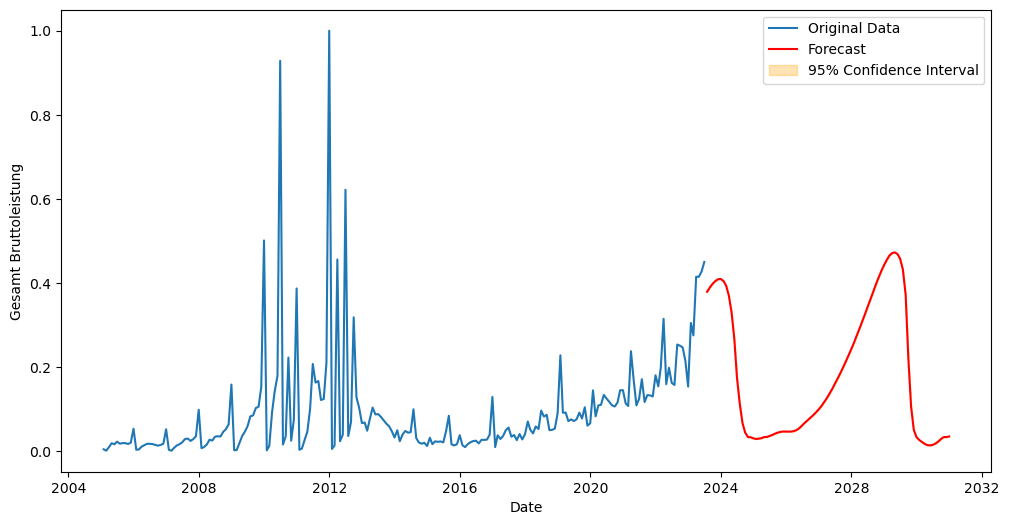

forecast_table             Forecast  Lower_CI  Upper_CI
Date                                    
2023-07-31  0.378460  0.378460  0.378460
2023-08-31  0.388700  0.388700  0.388700
2023-09-30  0.397242  0.397242  0.397242
2023-10-31  0.403871  0.403871  0.403871
2023-11-30  0.408205  0.408205  0.408205
...              ...       ...       ...
2030-08-31  0.021841  0.021841  0.021841
2030-09-30  0.027752  0.027752  0.027752
2030-10-31  0.032540  0.032540  0.032540
2030-11-30  0.032540  0.032540  0.032540
2030-12-31  0.033963  0.033963  0.033963

[90 rows x 3 columns]


In [72]:
# Forecasts ab Juli 2023 bis Dezember 2030
forecast_months = pd.date_range(start='2023-07-01', end='2030-12-31', freq='M')

forecast = []
confidence_intervals = []

future_data = scaled_data[-n_steps:]

for month in forecast_months:
    #print ('Input -> ', future_data)
    # print ('Input 2 -> ', np.array([future_data]))
    
    prediction = dropout_model.predict(np.array([future_data]))

    #print ('Forecast -> ', prediction[0][0])
    
    forecast.append(prediction[0][0])
    
    forecast_std = np.std(prediction)
    forecast_mean = prediction[0][0]
    confidence_intervals.append([forecast_mean - 1.96 * forecast_std, forecast_mean + 1.96 * forecast_std])

    
    #print ('future_data -> ', future_data)
    future_data = np.append(future_data[1:], prediction, axis=0)
    
    #print ('future_data -> ', future_data)

    #print ('forecast -> ', forecast)

   

# Erstellung einer Tabelle mit Forecast-Werten und Konfidenzintervallen
forecast_table = pd.DataFrame({'Date': forecast_months, 'Forecast': forecast,
                               'Lower_CI': [ci[0] for ci in confidence_intervals],
                               'Upper_CI': [ci[1] for ci in confidence_intervals]})

#print ('df table -> ', df)
#print ('forecast_table -> ', forecast_table)

# Umwandlung des Index in einen datetime-Index für die Visualisierung
forecast_table.set_index('Date', inplace=True)

#print ('forecast_table index -> ', forecast_table)
#print ('scaled_data -> ', scaled_data)

# Plot der Daten mit Forecast und Konfidenzintervallen
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaled_data, label='Original Data')
plt.plot(forecast_table.index, forecast_table['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_table.index, forecast_table['Lower_CI'], forecast_table['Upper_CI'],
                 color='orange', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Gesamt Bruttoleistung')
plt.legend()
plt.show()

# Ausgabe der Tabelle mit den Forecast-Werten und Konfidenzintervallen
print('forecast_table',forecast_table)
#print('scaled_data',scaled_data)